### Lane detection pipeline
This notebook is to test the detection on the lane lines. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def binary(img, s_thresh=(115, 255), l_thresh=(84, 255), sx_thresh=(25, 100)):
    """This function get an input image and return a binary images with
       lane lines detected. 
       The saturation, lightness, gradient thresholds can be customized 
       for experimentation. The default values are the one I found the best 
       choice for the images at hand"""

    # copy the input image to avoid changing it
    img = np.copy(img)

    # convert to HLS color space and separate the lightness
    # and saturation channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]

    # apply sobel filter in the x direction
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)

    # get the absolute value because also negative gradients represents
    # vertical changes
    abs_sobelx = np.absolute(sobelx)

    # redistribute values on the entire 0..255 range
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # threshold the x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[
        (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255

    # threshold the saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 255

    # convert to 8 bit
    s_binary = s_binary.astype(np.uint8)

    # threshold the lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 255
    l_binary = l_binary.astype(np.uint8)

    # convert to binary image where the lightess AND saturation bits have to be
    # both present to contribute, together with the gradient on x axes
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 255) & (s_binary == 255) | (sxbinary == 255))] = 255
    binary = np.dstack((binary, binary, binary))

    # return the images
    return binary

To discover the optimal threshold values, I used a quick and dirty util (test1.py) to change at runtime the values with a slider. This is the screenshot
![title](output_images/util.png)

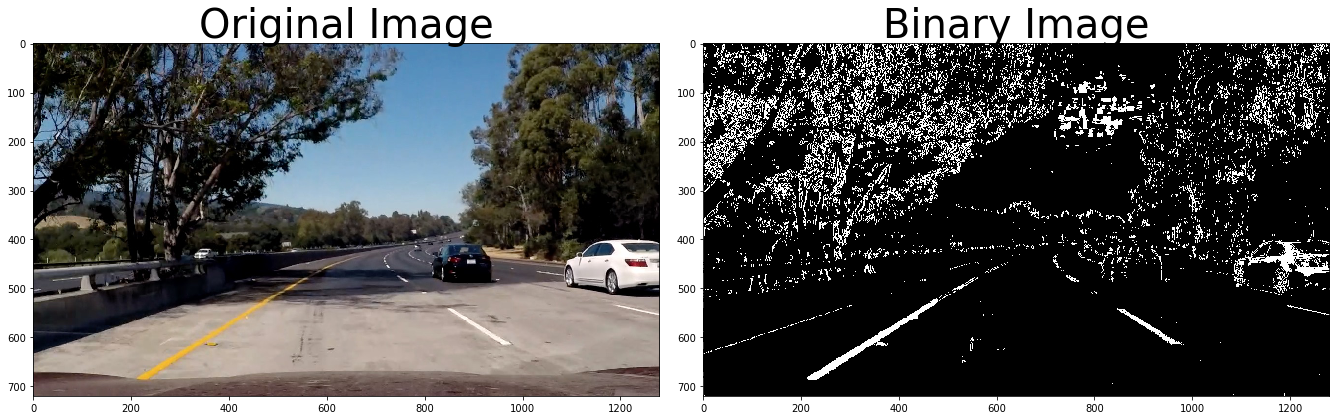

In [29]:
# load an image
img = plt.imread('test_images/test5.jpg')

# get the processed image
bin_img = binary(img)

# show original and binary
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(bin_img)
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#### Warp
This part define and apply a perspective function to the undistorted input images

In [26]:
# here we load the camera matrix and distortion coeffs to undistort images 
import pickle

with open(r"cmx.p", "rb") as cmx_file:
   cmx = pickle.load(cmx_file)

with open(r"dist.p", "rb") as dist_file:
   dist = pickle.load(dist_file)

In [23]:
def change_perspective(img, corners):
    """Change perspective on the input image, that has to be 
    undistorted. The corners are sent in the following order:
    bottom left, top left, top right, bottom right"""
    
    # create the source region
    src = np.float32(corners)
    
    # unpack the corners
    bl, tl, tr, br = corners 
    
    # adjust top left and top right corner to 
    # form a rectangle, to be used as destination
    tl = (bl[0], 0)
    tr = (br[0], 0)
    
    # create the destination rectangle
    dst = np.float32([bl, tl, tr, br])
    
    # calculate the matrix to transform from src to dst
    M = cv2.getPerspectiveTransform(src, dst)
    
    # and from dst to src
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

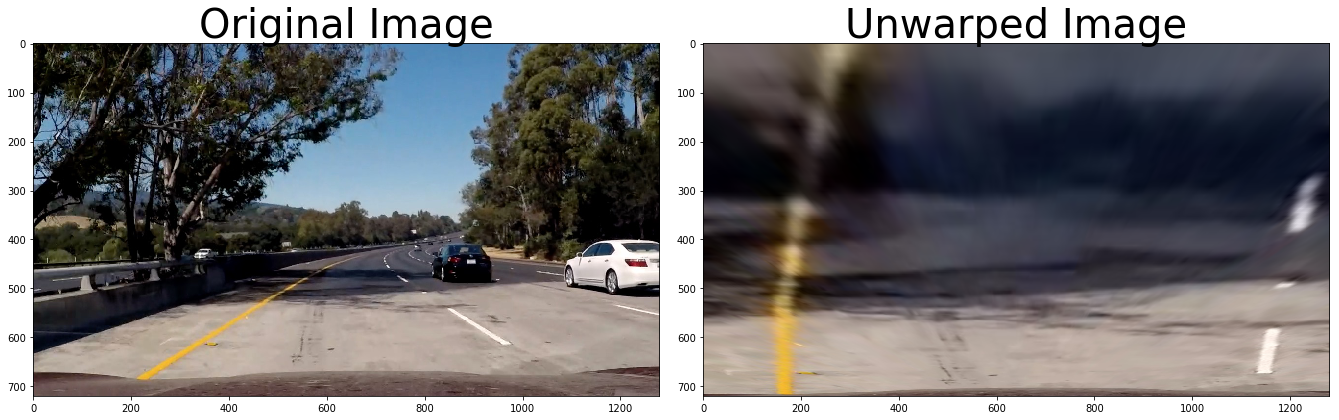

In [34]:
# define the trapezoid which encloses the road ahead
#corners = [(200, 720), (400, 500), (800, 500), (1100, 720)]
corners = [(190, 720), (589, 457), (698, 457), (1145, 720)]


# get the matrix to change perspective and the one to reverse
M, Minv = change_perspective(img, corners)
         
# undistort
dst_img = cv2.undistort(img, cmx, dist, None, cmx)

# image shape needed 
img_shape = (img.shape[1], img.shape[0])

# unwarp
unwarped = cv2.warpPerspective(dst_img, M, img_shape, flags=cv2.INTER_LINEAR)

# show original and unwarped
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(unwarped)
ax2.set_title('Unwarped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()